<a href="https://colab.research.google.com/github/inderjot29/Topic-Modeling/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have 4 tasks to do with the news articles dataset:

 1. Topic modeling: use this dataset to learn the different news topics that we have. 

 2.  Key-phrases extraction and ranking: identify best key phrases/ key words for each topic.

 3.  Emerging sub-topics identification: build topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 

 4.  Sentiment Analysis: identify topic sentiment for each article and also the overall daily sentiment for each topic
We will apply Latent Dirichlet Allocation (LDA) to convert a set of new articles to a set of topics. 

 **News articles topic modelling** is an unsupervised ML 
  method that helps us discover hidden semantic structures in an article, 
 that allows us to learn topic representations of papers in a corpus. 
 The model can be applied to ay kinds of lables on documents, 
 such as tags on post on the website. 

### The Process ### 

    # - Pick the number of topics ahead of time.
    # - Each document is represented as a distribution over topics 
    # - Each topic is represented as a distribution over words. 
    
 The news article text data is just a bunch of unlabeled texts

In [25]:
### Topic Modelling of news articles ### 

""" 
        @author:Inderjot Kaur Ratol
        Dependencies: nltk, spaCy, gensim. 
        Based on tutorials by Susan Li, "Topic Modeling and Latent Dirichlet Allocation (LDA) in Python"
        at https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
"""

# Ignore
import warnings
warnings.filterwarnings('ignore')

### The Data ### 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import sys
import csv
import itertools
csv.field_size_limit(sys.maxsize)
PATH = "articles1.csv"
df_all = pd.read_csv(PATH,engine='python',encoding='utf8',error_bad_lines=False) # load into a data-frame 
#print("df\n",df_all.head())

# In order to keep it simple , and for reference, we will use only two of the columns
dfyear = df_all.groupby('year')
dfyear =pd.concat([x for _, x in itertools.islice(dfyear, 4)])
df_content = dfyear[['content']]
print("\ndf_content\n",df_content.head())
len(df_content)

Skipping line 34200: unexpected end of data


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

data = []
 
for article in df_content.values[0:2000]:
    document = ' '.join(article)
    data.append(document)
 
NO_DOCUMENTS = len(data)
print(NO_DOCUMENTS)

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z][a-zA-Z]{2,}')
data_vectorized = vectorizer.fit_transform(data)

2000


In [0]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [0]:

import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Text(0, 0.5, 'Frequency')

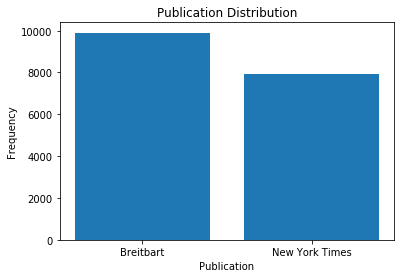

In [0]:
import matplotlib.pyplot as plt
# create a figure and axis 
fig, ax = plt.subplots() 
# count the occurrence of each class 
data = df_all['publication'].value_counts() 
# get x and y data 
points = data.index 
frequency = data.values 
# create bar chart 
ax.bar(points, frequency) 
# set title and labels 
ax.set_title('Publication Distribution') 
ax.set_xlabel('Publication') 
ax.set_ylabel('Frequency')

In [0]:
### Text Cleaning ### 

## Lemmatizing 
import re
import nltk
import gensim
import pickle
from gensim import models, corpora
from gensim.models import CoherenceModel
from smart_open import smart_open
nltk.download('stopwords')
nltk.download('punkt') 
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nlp_en = spacy.load("en_core_web_sm")

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  
# Build the bigram models
def bigrams(words, bi_min=15):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
  
  # Build the bigram models
def trigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod
  
def make_bigrams(texts):
    bigram_mod = bigrams(texts)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram_mod = bigrams(texts)
    trigram_mod = trigrams(texts)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# create a filtered lemmas to exclude determiners (DET), adpositions(aka prepositions) (ADP), 
# punctuation (PUNCT), conjuctions (CONJ,CCONJ),subordinating conjunction(SCONJ), numerals (NUM), symbols (SYM), spaces (SPACE),
# auxillary (AUX), particle (PART), pronoun (PRON), helping verb (HVS), interjection(INTJ)
# and non-alpha tokens. We will also filter stopwords. 
# Full list can be found at https://spacy.io/api/annotation
# allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
# filter_tags = ["DET","ADP","PUNCT","CONJ","CCONJ","SCONJ","NUM","SYM","SPACE","AUX","PART","PRON","HVS","INTJ"]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        lemmas = [(token.text, token.lemma_) for token in doc if token.pos_ in allowed_postags 
                  and token.text.isalpha() and len( str(token.lemma_)) > 3]
        texts_out.append([lemma[1] for lemma in lemmas])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(df_content[0:315].values.tolist()))
data_words = list(sent_to_words(df_content.values.tolist()))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
lemmatized_data = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Form Bigrams
#lemmatized_data = make_bigrams(lemmatized_data)
# Form Trigrams
lemmatized_data = make_trigrams(lemmatized_data)
print(lemmatized_data[:1])

[['washington', 'pharmaceutical', 'giant', 'merck', 'plead_guilty', 'charge', 'relate', 'illegal', 'promotional', 'activity', 'painkiller', 'vioxx', 'fine', 'settlement', 'cost', 'total', 'nearly', 'dollar', 'justice_department', 'announce', 'tuesday', 'justice', 'official', 'merck', 'sharp', 'dohme', 'corp', 'agree', 'massive', 'settlement', 'resolve', 'criminal', 'charge', 'civil', 'claim', 'stem', 'promotion', 'marketing', 'vioxx', 'drug', 'withdraw', 'marketplace', 'september', 'agreement', 'merck', 'plead', 'misdemeanor', 'charge', 'illegal', 'promotion', 'criminal', 'fine', 'firm', 'also', 'agree', 'civil', 'settlement', 'resolve', 'allegation', 'market', 'false', 'statement', 'cardiovascular', 'safety', 'vioxx', 'federal', 'government', 'receive', 'civil', 'settlement', 'remain', 'distribute', 'participate', 'medicaid', 'state', 'justice_department', 'pharmaceutical', 'company', 'ignore', 'rule', 'keep', 'medicine', 'safe', 'effective', 'company', 'undermine', 'ability', 'health

In [0]:
NUM_TOPICS = 10
 
# Create Dictionary
train_id2word = corpora.Dictionary(lemmatized_data)
#train_id2word.filter_extremes(no_below=100, no_above=0.35,keep_n=100000)
#train_id2word.compactify()

# Term Document Frequency
train_corpus = [train_id2word.doc2bow(text) for text in lemmatized_data]
tfidf_model = gensim.models.TfidfModel(train_corpus)
train_corpus = tfidf_model[train_corpus]
# Save the corpus with pickle
pickle.dump(train_corpus, smart_open('corpus.pkl', 'wb'))
train_id2word.save('dictionary.gensim') 
 
# Human readable format of corpus (term-frequency)
[[(train_id2word[id], freq) for id, freq in cp] for cp in train_corpus[:1]]


[[('ability', 0.05501159144693982),
  ('activity', 0.05074027364668909),
  ('agree', 0.07281471826114062),
  ('agreement', 0.07281471826114062),
  ('allegation', 0.05275001386778117),
  ('also', 0.013286033539084505),
  ('announce', 0.01439642613842726),
  ('approve', 0.0837892163765038),
  ('april', 0.012127365006482642),
  ('arthritis', 0.1497249171520706),
  ('assistant', 0.0418946081882519),
  ('attorney_general', 0.04651907803653471),
  ('behalf', 0.0562582262596658),
  ('cardiovascular', 0.0840925861543546),
  ('charge', 0.07295482799537063),
  ('civil', 0.11757814084013758),
  ('claim', 0.05234627560644463),
  ('company', 0.0650965612170887),
  ('corp', 0.060615792614812994),
  ('cost', 0.04651907803653471),
  ('criminal', 0.07643154188149827),
  ('decision', 0.04248708874099985),
  ('distribute', 0.0748624585760353),
  ('dohme', 0.10394345328345009),
  ('dollar', 0.047288089324326966),
  ('drug', 0.04893186183651027),
  ('effective', 0.0562582262596658),
  ('false', 0.059043580

In [0]:
# Build the LDA model
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=NUM_TOPICS,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

lda_train.save('model_lda_train.gensim')

#View the topics in LDA model with Keyword Rankings
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next

In [0]:
from pprint import pprint
# Print the Keyword in the topics
pprint(lda_train.print_topics())
doc_lda = lda_train[train_corpus]

[(0,
  '0.001*"president" + 0.001*"senate" + 0.001*"award" + 0.001*"photo" + '
  '0.001*"people" + 0.001*"country" + 0.001*"good" + 0.001*"race" + '
  '0.001*"january" + 0.001*"game"'),
 (1,
  '0.001*"madoff" + 0.001*"wiesel" + 0.001*"sharif" + 0.001*"hernandez" + '
  '0.001*"letterman" + 0.001*"sheen" + 0.001*"domino" + 0.001*"stanley" + '
  '0.001*"robert_kennedy" + 0.001*"breakup"'),
 (2,
  '0.001*"cosby" + 0.001*"taliban" + 0.001*"pont" + 0.001*"rousseff" + '
  '0.001*"christie" + 0.001*"reid" + 0.001*"ramsey" + 0.001*"bernanke" + '
  '0.001*"south_sudan" + 0.001*"spelling"'),
 (3,
  '0.001*"blagojevich" + 0.001*"zuma" + 0.001*"evident" + 0.001*"smallpox" + '
  '0.001*"anthrax" + 0.001*"stem_cell" + 0.001*"superhero" + 0.001*"blake" + '
  '0.001*"mccartney" + 0.001*"tattoo"'),
 (4,
  '0.001*"boko_haram" + 0.001*"nader" + 0.001*"thatcher" + 0.001*"spank" + '
  '0.001*"allison" + 0.001*"sxsw" + 0.000*"elvi" + 0.000*"bell" + '
  '0.000*"libby" + 0.000*"drawing"'),
 (5,
  '0.001*"badas

#Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_train, texts=lemmatized_data, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.265015019711784

Coherence Score:  0.7001704224710783


In [0]:
# Build the LSI model
lsi_model = models.LsiModel(corpus=train_corpus, num_topics=NUM_TOPICS, id2word=train_id2word)

lsi_model.save('model_lsi.gensim')
# Get the topics 
print("LSI topics\n")
lsi_model.show_topics(num_topics=5)  # Showing only the top 5 topics

LSI topics



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.155*"woman" + 0.151*"company" + 0.136*"question" + 0.118*"republican" + 0.114*"family" + 0.097*"write" + 0.090*"white_house" + 0.089*"case" + 0.085*"home" + 0.084*"percent"'),
 (1,
  '-0.511*"woman" + 0.328*"republican" + 0.196*"democrat" + -0.137*"family" + -0.136*"child" + 0.131*"white_house" + 0.126*"party" + 0.123*"russia" + 0.111*"bill" + -0.109*"home"'),
 (2,
  '0.455*"company" + -0.393*"woman" + -0.361*"question" + 0.164*"china" + -0.155*"russia" + -0.146*"republican" + -0.141*"vote" + -0.131*"democrat" + 0.108*"business" + -0.097*"talk"'),
 (3,
  '-0.454*"question" + 0.351*"republican" + 0.343*"woman" + -0.243*"russia" + 0.170*"vote" + 0.167*"democrat" + 0.159*"bill" + 0.157*"party" + -0.122*"talk" + -0.119*"deal"'),
 (4,
  '-0.550*"woman" + -0.426*"company" + 0.179*"family" + -0.173*"china" + 0.148*"school" + 0.141*"child" + 0.121*"student" + 0.119*"game" + 0.112*"mother" + 0.111*"live"')]

 # Visualize the topics-keywords
 
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [0]:
import gensim
!pip install pyLDAvis
# We can now output a visualization of the possible topics

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
lda = gensim.models.LdaModel.load('model_lda_train.gensim')

# Library to visualize the LDA
import pyLDAvis.gensim

# set up the display features 
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=train_id2word, corpus=train_corpus, texts=lemmatized_data, start=2, limit=60, step=6)

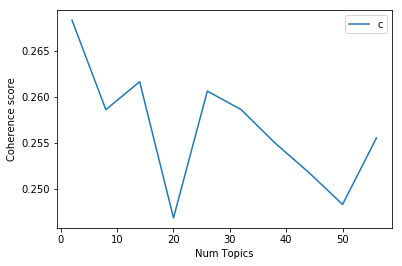

In [0]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2684
Num Topics = 8  has Coherence Value of 0.2586
Num Topics = 14  has Coherence Value of 0.2617
Num Topics = 20  has Coherence Value of 0.2468
Num Topics = 26  has Coherence Value of 0.2606
Num Topics = 32  has Coherence Value of 0.2586
Num Topics = 38  has Coherence Value of 0.255
Num Topics = 44  has Coherence Value of 0.2518
Num Topics = 50  has Coherence Value of 0.2483
Num Topics = 56  has Coherence Value of 0.2555


#Sub-topic idenitification over a period of time using DTM

 Topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 

In [0]:
#prepare the data for sub-topics identification by grouping the data based on year and month
df_year = df_all.groupby('year')
df_count_per_year = df_year.size().reset_index(name='count_per_year')
df_year_month = df_all.groupby(['year', 'month'])

#lets get the counts per year and per month
df_count_per_month = df_year_month.size().reset_index(name='count_per_month')
#df_count_per_month
df_count_per_year

,year,count_per_year
0,2011.0,1
1,2012.0,26
2,2013.0,212
3,2014.0,76
4,2015.0,3326
5,2016.0,28451
6,2017.0,17908


In [0]:
# setting up our imports

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

In [0]:
time_slice = [1, 26, 212,76]

In [0]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=10)
ldaseq.save('ldaseq.gensim')

#Visualizing Topics
The input parameter to print_topics is a time-slice option. By passing 0 we are seeing the topics in the 1st time-slice.

In [0]:
ldaseq.print_topics(time=0)

We can see 10 different fairly well defined topics:

1.   List item
2.   List item



#Looking for Topic Evolution
To fix a topic and see it evolve, use print_topic_times. The input parameter is the topic_id In this case, we are looking at the evolution of the technology topi

In [0]:
ldaseq.print_topic_times(topic=0)

#Document - Topic Proportions
The function doc_topics checks the topic proportions on documents already trained on. It accepts the document number in the corpus as an input.

Let's pick up document number 300 arbitrarily and have a look.

In [0]:
# to check Document - Topic proportions, use `doc-topics`
words = [train_id2word[word_id] for word_id, count in train_corpus[300]]
print (words)

doc = ldaseq.doc_topics(300) # check the 300th document in the corpuses topic distribution
print (doc)

#Choosing your best Dynamic Topic Model
Like we've been going on and on before, the advantage in having a python port is the transparency with which you can train your DTM. We'll go over two key ideas: changing variance, and changing suff stats.

Chain Variance
One of the key aspects of topic evolution is how fast/slow these topics evolve. And this is where the factor of variance comes in. By setting the chain_variance input to the DTM model higher, we can tweak our topic evolution. The default value is 0.005. (this is the value suggested by Blei in his tech talk and is the default value in the C++ code)

Let us see a small example illustrating the same. Let's first see the evolution of values for the first time-slice

In [0]:
ldaseq.print_topic_times(1)

In [0]:
ldaseq_chain = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=10, chain_variance=0.05)
ldaseq_chain.save('ldaseq_chain.gensim')
ldaseq_chain.print_topic_times(2)

#Visualising Dynamic Topic Models
Let us use pyLDAvis to visualise both the DTM wrapper and DTM python port. With the new DTMvis methods it is now very straightforward to visualise DTM for a particular time-slice.

In [0]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

lda_seq = gensim.models.ldaseq.load('ldaseq.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
doc_topic, topic_term, doc_lengths, term_frequency, vocab = lda_seq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

#Topic Coherence for LDASEQ (DTM)

In [0]:
from gensim.models.coherencemodel import CoherenceModel
import pickle

# we just have to specify the time-slice we want to find coherence for.
topics_dtm = ldaseq.dtm_coherence(time=2)

# running u_mass coherence on our model
cm_DTM = CoherenceModel(topics=topics_dtm, corpus=corpus, dictionary=dictionary, coherence='u_mass')

print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())